In [1]:
# %% Initialize

import numpy as np
import matplotlib.pyplot as plt
import pickle


# own class
from Algorithms import Bregman_SoR, NASA_SoR, SCSC_SoR

# plot setting
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "ps.usedistiller": "xpdf"})

# Parameters
d = 50  # dimension of matrix
n = 1000  # number of random matrix
lmbda = 10  # weight of var part
R = 10  # constraint norm(x) <= R
noise_level = 3
Lf = 2*lmbda
Lg = 1
tau = min(0.5, Lf/(Lf+8), 1/Lf) / 2
beta = Lf * tau

# Generate data
np.random.seed(10)
A_avg = np.random.randn(d, d)
A_avg = (A_avg+A_avg.T)/2
noise = np.random.randn(d, d, n)
A = np.tile(A_avg[:, :, np.newaxis], (1, 1, n)) + \
    noise_level * (noise+np.swapaxes(noise, 0, 1)) / \
    2    # make sure A are all symmetric

A_avg = A.mean(axis=2)  # Mean of matrix A based on the generated data

A_avg_norm = np.linalg.norm(A_avg, 2)
A_norm2_avg = np.mean(np.linalg.norm(A, axis=(0, 1), ord=2)
                      ** 2)  # calculate (E[|A_xi|^2])


x_init = np.random.randn(d)
x_init = x_init/np.linalg.norm(x_init)*R  # initial point


In [2]:
oracles = 60000  # total oracles to samples
batch_list = [300, 100, 50]
number_experiment = 20  # number of repeated experiment


# function values
BG_Fval, SCSC_Fval, NASA_Fval = [
    np.zeros([len(batch_list), number_experiment, oracles]) for _ in range(3)]

# averaged Dh1, Dh2
BG_Dh1_avg, SCSC_Dh1_avg, NASA_Dh1_avg = [
    np.zeros([len(batch_list), number_experiment, oracles]) for _ in range(3)]
BG_Dh2_avg, SCSC_Dh2_avg, NASA_Dh2_avg = [
    np.zeros([len(batch_list), number_experiment, oracles]) for _ in range(3)]

# determinastic gradient and sampled gradient norms
BG_gradF_det, SCSC_gradF_det, NASA_gradF_det = [
    np.zeros([len(batch_list), number_experiment, oracles]) for _ in range(3)]
BG_gradF, SCSC_gradF, NASA_gradF = [
    np.zeros([len(batch_list), number_experiment, oracles]) for _ in range(3)]


# read data
for idx_batch in range(len(batch_list)):
    max_iter = oracles // batch_list[idx_batch]
    for idx_exp in range(number_experiment):

        with open(f'Results/Experiments/Breg_batch{batch_list[idx_batch]}_exp{idx_exp}.pickle', 'rb') as file:
            Breg_exp = pickle.load(file)
        BG_Fval[idx_batch, idx_exp, 0:max_iter] = Breg_exp.val_F_traj
        BG_Dh1_avg[idx_batch, idx_exp, 0:max_iter] = Breg_exp.Dh1_avg_traj
        BG_Dh2_avg[idx_batch, idx_exp, 0:max_iter] = Breg_exp.Dh2_avg_traj
        BG_gradF_det[idx_batch, idx_exp, 0:max_iter] = np.linalg.norm(
            Breg_exp.grad_Fdet_traj, ord=2, axis=0) ** 2
        BG_gradF[idx_batch, idx_exp, 0:max_iter] = np.linalg.norm(
            Breg_exp.grad_F_traj, ord=2, axis=0) ** 2

        with open(f'Results/Experiments/SCSC_batch{batch_list[idx_batch]}_exp{idx_exp}.pickle', 'rb') as file:
            SCSC_exp = pickle.load(file)
        SCSC_Fval[idx_batch, idx_exp, 0:max_iter] = SCSC_exp.val_F_traj
        SCSC_Dh1_avg[idx_batch, idx_exp, 0:max_iter] = SCSC_exp.Dh1_avg_traj
        SCSC_Dh2_avg[idx_batch, idx_exp, 0:max_iter] = SCSC_exp.Dh2_avg_traj
        SCSC_gradF_det[idx_batch, idx_exp, 0:max_iter] = np.linalg.norm(
            SCSC_exp.grad_Fdet_traj, ord=2, axis=0) ** 2
        SCSC_gradF[idx_batch, idx_exp, 0:max_iter] = np.linalg.norm(
            SCSC_exp.grad_F_traj, ord=2, axis=0) ** 2

        with open(f'Results/Experiments/NASA_batch{batch_list[idx_batch]}_exp{idx_exp}.pickle', 'rb') as file:
            NASA_exp = pickle.load(file)
        NASA_Fval[idx_batch, idx_exp, 0:max_iter] = NASA_exp.val_F_traj
        NASA_Dh1_avg[idx_batch, idx_exp, 0:max_iter] = NASA_exp.Dh1_avg_traj
        NASA_Dh2_avg[idx_batch, idx_exp, 0:max_iter] = NASA_exp.Dh2_avg_traj
        NASA_gradF_det[idx_batch, idx_exp, 0:max_iter] = np.linalg.norm(
            NASA_exp.grad_Fdet_traj, ord=2, axis=0) ** 2
        NASA_gradF[idx_batch, idx_exp, 0:max_iter] = np.linalg.norm(
            NASA_exp.grad_F_traj, ord=2, axis=0) ** 2


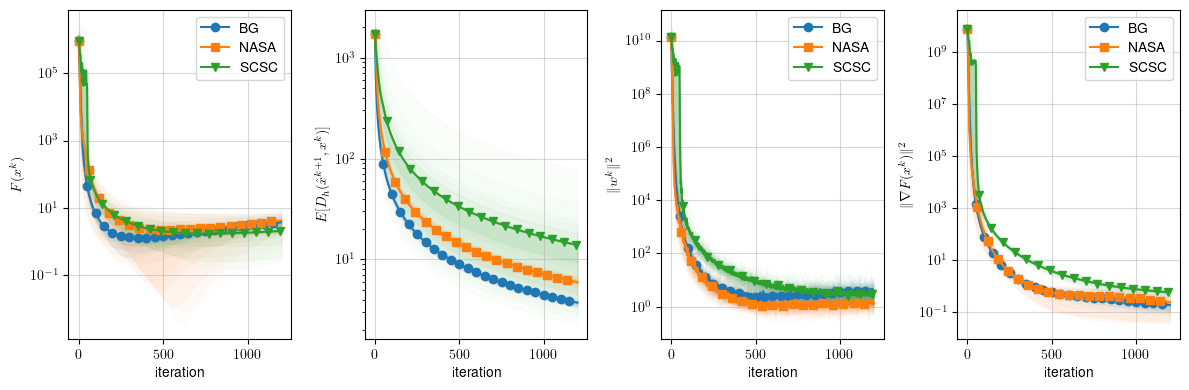

In [5]:
def plot_line(data, ax, **kwargs):
    # plot each experiment and their average
    # array shape n x L, where n is the number of experiment, L is the length of one experiment

    color, label, marker, markevery = kwargs.get('color'), kwargs.get(
        'label'), kwargs.get('marker'), kwargs.get('markevery')
    alpha = kwargs.get('alpha', 0.01)

    data_mean = np.mean(data, axis=0)

    ax.plot(data_mean, color=color, label=label,
            marker=marker, markevery=markevery)
    for idx in range(data.shape[0]):
        ax.fill_between(range(data.shape[1]),
                        data[idx, :], data_mean, color=color, alpha=alpha)

kwargs_plot = {'BG': {'color': 'C0', 'marker': 'o', 'markevery': 50, 'label': 'BG'},
               'NASA': {'color': 'C1', 'marker': 's', 'markevery': 60, 'label': 'NASA'},
               'SCSC': {'color': 'C2', 'marker': 'v', 'markevery': 70, 'label': 'SCSC'},
               'fill': {'alpha': 0.02}
               }


fig, axs = plt.subplots(1, 4, figsize=(12, 4))

## plot
idx_batch = 2
max_iter = oracles // batch_list[idx_batch]

# function values
ax = axs[0]
plot_line(BG_Fval[idx_batch, :, 0:max_iter], ax, **kwargs_plot['BG'] | kwargs_plot['fill'])
plot_line(NASA_Fval[idx_batch, :, 0:max_iter], ax, **
          kwargs_plot['NASA'] | kwargs_plot['fill'])
plot_line(SCSC_Fval[idx_batch, :, 0:max_iter], ax, **
          kwargs_plot['SCSC'] | kwargs_plot['fill'])
ax.legend()
ax.set_ylabel(r"$F(x^k)$")

# Dh1+Dh2
ax = axs[1]
plot_line(Breg_exp.k1 * BG_Dh1_avg[idx_batch, :, 0:max_iter] + Breg_exp.k2 * BG_Dh2_avg[idx_batch, :, 0:max_iter], ax, **kwargs_plot['BG'] | kwargs_plot['fill'])
plot_line(Breg_exp.k1 * NASA_Dh1_avg[idx_batch, :, 0:max_iter] + Breg_exp.k2 * NASA_Dh2_avg[idx_batch, :, 0:max_iter], ax, **kwargs_plot['NASA'] | kwargs_plot['fill'])
plot_line(Breg_exp.k1 * SCSC_Dh1_avg[idx_batch, :, 0:max_iter] + Breg_exp.k2 * SCSC_Dh2_avg[idx_batch, :, 0:max_iter], ax, **kwargs_plot['SCSC'] | kwargs_plot['fill'])
ax.set_ylabel(r"$E[D_{h}(\hat{x}^{k+1}, x^k)]$")

# norm grad F(stochastic)
ax = axs[2]
plot_line(BG_gradF[idx_batch, :, 0:max_iter], ax, **kwargs_plot['BG'] | kwargs_plot['fill'])
plot_line(NASA_gradF[idx_batch, :, 0:max_iter], ax, **
          kwargs_plot['NASA'] | kwargs_plot['fill'])
plot_line(SCSC_gradF[idx_batch, :, 0:max_iter], ax, **
          kwargs_plot['SCSC'] | kwargs_plot['fill'])
ax.legend()
ax.set_ylabel(r"$\|w^k\|^2$")


# norm grad Fdet
ax = axs[3]
plot_line(BG_gradF_det[idx_batch, :, 0:max_iter], ax, **kwargs_plot['BG'] | kwargs_plot['fill'])
plot_line(NASA_gradF_det[idx_batch, :, 0:max_iter], ax, **
          kwargs_plot['NASA'] | kwargs_plot['fill'])
plot_line(SCSC_gradF_det[idx_batch, :, 0:max_iter], ax, **
          kwargs_plot['SCSC'] | kwargs_plot['fill'])
ax.legend()
ax.set_ylabel(r"$\|\nabla F(x^k)\|^2$")

for ax in axs.flat:
    ax.set_xlabel("iteration")
    ax.set_yscale("log")
    ax.grid(True, alpha=0.5)
fig.tight_layout()

filename = f"Plots/Compare_batch{batch_list[idx_batch]}.pdf"
plt.savefig(filename)